In [76]:
pip install tensorflow_datasets

In [77]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [78]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
    

In [79]:
imdb

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'unsupervised': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [80]:
train_data,test_data = imdb['train'], imdb['test']

In [81]:
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels= []
for sent, labl in train_data:
  training_sentences.append(str(sent.numpy())) # sent is of tensor datatype
  training_labels.append(labl.numpy())

for sent,labl in test_data:
  testing_sentences.append(str(sent.numpy()))
  testing_labels.append(labl.numpy())

In [82]:
print(training_labels[100])

1


In [83]:
len(training_labels),  len(testing_labels)

(25000, 25000)

In [84]:
type(training_labels) # keras need array , they dont work on list

list

In [85]:
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

### Preprocessing

In [86]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [87]:
tokenizer = Tokenizer(num_words=10000) #num_words=10000: This is an argument being passed to the Tokenizer. It tells the Tokenizer to only keep the top 10,000 most frequent words in its vocabulary. Any words encountered beyond the top 10,000 will be treated as out-of-vocabulary (OOV) words. This is a common technique to limit the size of the vocabulary and focus on the most important words for the task.

In [88]:
tokenizer.fit_on_texts(training_sentences)

In [89]:
word_index= tokenizer.word_index

In [90]:
word_index

{'the': 1,
 'and': 2,
 'a': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'br': 7,
 'in': 8,
 'it': 9,
 'i': 10,
 'this': 11,
 'that': 12,
 'was': 13,
 'as': 14,
 'for': 15,
 'with': 16,
 'movie': 17,
 'but': 18,
 'film': 19,
 "'s": 20,
 'on': 21,
 'you': 22,
 'not': 23,
 'are': 24,
 'his': 25,
 'he': 26,
 'have': 27,
 'be': 28,
 'one': 29,
 'all': 30,
 'at': 31,
 'by': 32,
 'they': 33,
 'an': 34,
 'who': 35,
 'so': 36,
 'from': 37,
 'like': 38,
 'her': 39,
 "'t": 40,
 'or': 41,
 'just': 42,
 'there': 43,
 'about': 44,
 'out': 45,
 "'": 46,
 'has': 47,
 'if': 48,
 'some': 49,
 'what': 50,
 'good': 51,
 'more': 52,
 'very': 53,
 'when': 54,
 'she': 55,
 'up': 56,
 'can': 57,
 'b': 58,
 'time': 59,
 'no': 60,
 'even': 61,
 'my': 62,
 'would': 63,
 'which': 64,
 'story': 65,
 'only': 66,
 'really': 67,
 'see': 68,
 'their': 69,
 'had': 70,
 'were': 71,
 'me': 72,
 'well': 73,
 'we': 74,
 'than': 75,
 'much': 76,
 'been': 77,
 'get': 78,
 'bad': 79,
 'will': 80,
 'people': 81,
 'do': 82,
 'also': 83,


In [91]:
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=500, truncating='post')
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=500, truncating= 'post')

In [92]:
padded


array([[   0,    0,    0, ...,  873,  144,    9],
       [   0,    0,    0, ...,   31,   30,   46],
       [   0,    0,    0, ...,    8, 6175,   46],
       ...,
       [7628,   36,   10, ...,   20,   83,    1],
       [   0,    0,    0, ..., 1320,   22,   46],
       [   0,    0,    0, ..., 1697,  661,   46]], dtype=int32)

In [93]:
padded.shape

(25000, 500)

### Import the libraries

In [94]:
from keras.layers import Dense, Embedding, SimpleRNN, Bidirectional, LSTM, GRU
from keras.models import Sequential

### Build simple RNN Model

In [95]:
model_rnn = Sequential([
    Embedding(10000, 50, input_length=50), # 10000 is the voab_size, 50 is vector size(embedding vector)
    # input_length=50: Sequence Length
# This specifies the length of each input sequence.
# If your input sequences are shorter than 50, they are typically padded with zeros to match this length.
# If they are longer, they are truncated to 50 tokens.
    SimpleRNN(32),
    Dense(10, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [96]:
model_rnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [97]:
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [98]:
history = model_rnn.fit(padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 68ms/step - accuracy: 0.5648 - loss: 0.6664 - val_accuracy: 0.7038 - val_loss: 0.5674
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 66ms/step - accuracy: 0.8180 - loss: 0.4156 - val_accuracy: 0.8172 - val_loss: 0.4192
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 66ms/step - accuracy: 0.8979 - loss: 0.2574 - val_accuracy: 0.8080 - val_loss: 0.4842
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.9509 - loss: 0.1418 - val_accuracy: 0.7912 - val_loss: 0.5815
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 78s 65ms/step - accuracy: 0.9721 - loss: 0.0795 - val_accuracy: 0.7940 - val_loss: 0.7076
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 66ms/step - accuracy: 0.9890 - loss: 0.0362 - val_accuracy: 0.7791 - val_loss: 0.8966
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - accuracy: 0.9948 - loss: 0.0193 - val_accuracy: 0.7494 - val_loss: 1.0320
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.9911 - loss: 0.0263 - 

<Axes: >

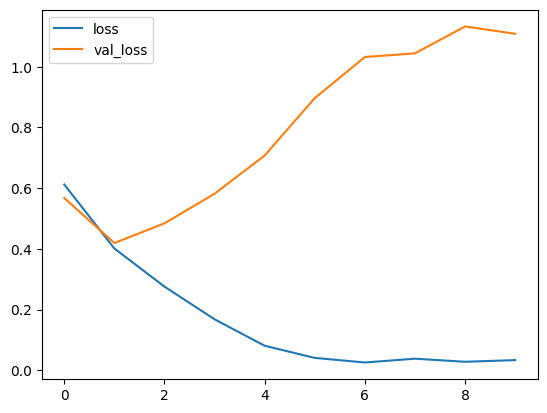

In [99]:
import pandas as pd
loss_df = pd.DataFrame(history.history)
loss_df.plot(y = ['loss', 'val_loss'])

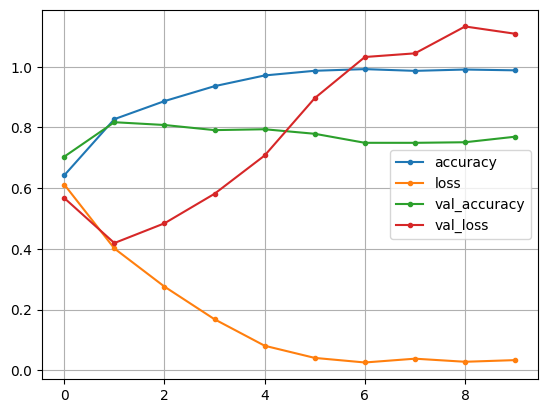

In [100]:
loss_df.plot(marker = ".", grid = True);

In [101]:
import matplotlib.pyplot as plt

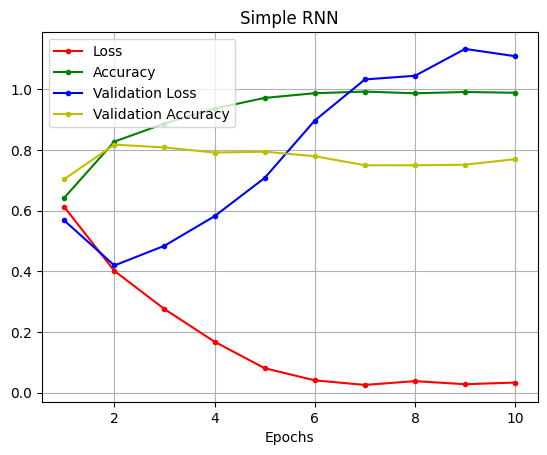

In [102]:
plt.title('Simple RNN')
plt.xlabel('Epochs')
plt.grid()
plt.plot(range(1,11),history.history['loss'],color ='r' ,label = "Loss",marker = ".")
plt.plot(range(1,11),history.history['accuracy'],color ='g' ,label = "Accuracy",marker = ".")
plt.plot(range(1,11),history.history['val_loss'],color ='b' ,label = "Validation Loss",marker = ".")
plt.plot(range(1,11),history.history['val_accuracy'],color ='y' ,label = "Validation Accuracy",marker = ".")
plt.legend(loc = 'upper left')

In [103]:
history = model_rnn.fit(padded, training_labels, epochs=10,batch_size=64, validation_data=(testing_padded, testing_labels))

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.9968 - loss: 0.0109 - val_accuracy: 0.7764 - val_loss: 1.1842
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.9998 - loss: 0.0017 - val_accuracy: 0.7694 - val_loss: 1.2819
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 1.0000 - loss: 4.4500e-04 - val_accuracy: 0.7671 - val_loss: 1.3639
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 1.0000 - loss: 2.8643e-04 - val_accuracy: 0.7718 - val_loss: 1.3951
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 1.0000 - loss: 1.9374e-04 - val_accuracy: 0.7729 - val_loss: 1.4400
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 1.0000 - loss: 1.3391e-04 - val_accuracy: 0.7732 - val_loss: 1.4841
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 1.0000 - loss: 9.6734e-05 - val_accuracy: 0.7731 - val_loss: 1.5266
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 1.00

<Axes: >

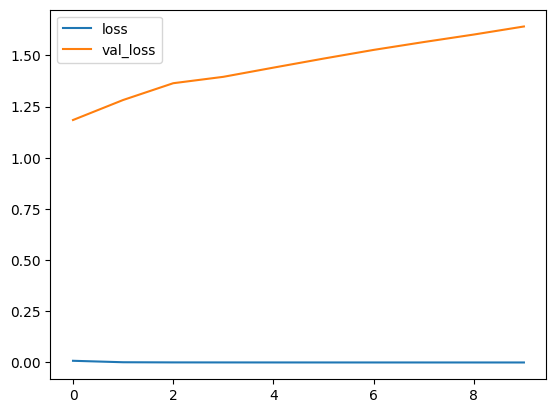

In [104]:
import pandas as pd
loss_df = pd.DataFrame(history.history)
loss_df.plot(y = ['loss', 'val_loss'])

# bidirectional LSTM

In [105]:
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 50, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [106]:
model_lstm.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [107]:
history_lstm = model_lstm.fit(padded, training_labels, epochs=10, batch_size=64,
                              validation_data=(testing_padded, testing_labels))

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.6910 - loss: 0.5483 - val_accuracy: 0.8289 - val_loss: 0.4053
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9024 - loss: 0.2646 - val_accuracy: 0.8673 - val_loss: 0.3133
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9380 - loss: 0.1752 - val_accuracy: 0.8696 - val_loss: 0.3216
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9475 - loss: 0.1461 - val_accuracy: 0.8694 - val_loss: 0.3652
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9637 - loss: 0.1062 - val_accuracy: 0.8681 - val_loss: 0.4329
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9737 - loss: 0.0797 - val_accuracy: 0.8650 - val_loss: 0.4478
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9808 - loss: 0.0610 - val_accuracy: 0.8619 - val_loss: 0.4904
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9820 - loss: 0.0555 - 

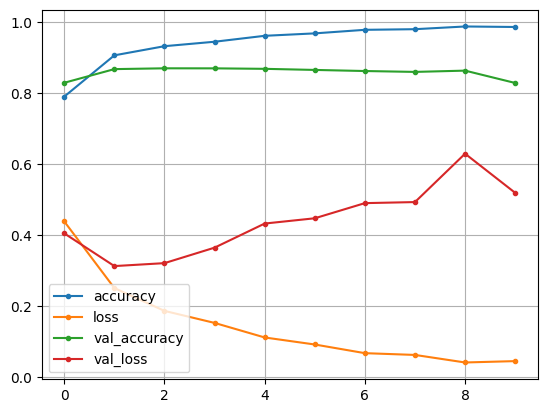

In [108]:
loss_df = pd.DataFrame(history_lstm.history)
loss_df.plot(marker = ".", grid = True);

# bidirectional GRU

In [109]:
model_GRU = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 50, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [110]:
model_GRU.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [111]:
history_gru = model_GRU.fit(padded, training_labels, epochs=10, batch_size=64,
                              validation_data=(testing_padded, testing_labels))

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.6543 - loss: 0.5844 - val_accuracy: 0.8372 - val_loss: 0.3820
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.8784 - loss: 0.3038 - val_accuracy: 0.8396 - val_loss: 0.3700
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9072 - loss: 0.2410 - val_accuracy: 0.8189 - val_loss: 0.4324
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9325 - loss: 0.1834 - val_accuracy: 0.8607 - val_loss: 0.3423
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9561 - loss: 0.1318 - val_accuracy: 0.8540 - val_loss: 0.4008
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9634 - loss: 0.1116 - val_accuracy: 0.8619 - val_loss: 0.4037
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9738 - loss: 0.0826 - val_accuracy: 0.8596 - val_loss: 0.4578
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9812 - loss: 0.0647 - 

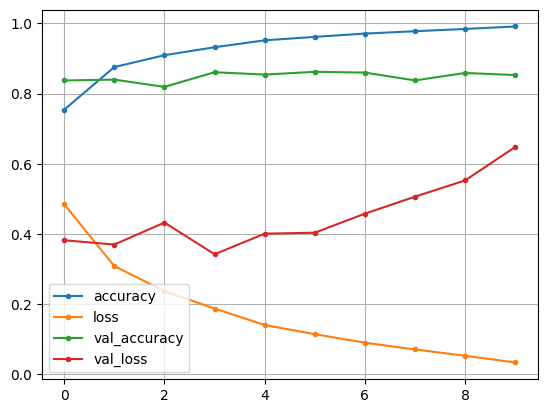

In [112]:
loss_df = pd.DataFrame(history_gru.history)
loss_df.plot(marker = ".", grid = True);

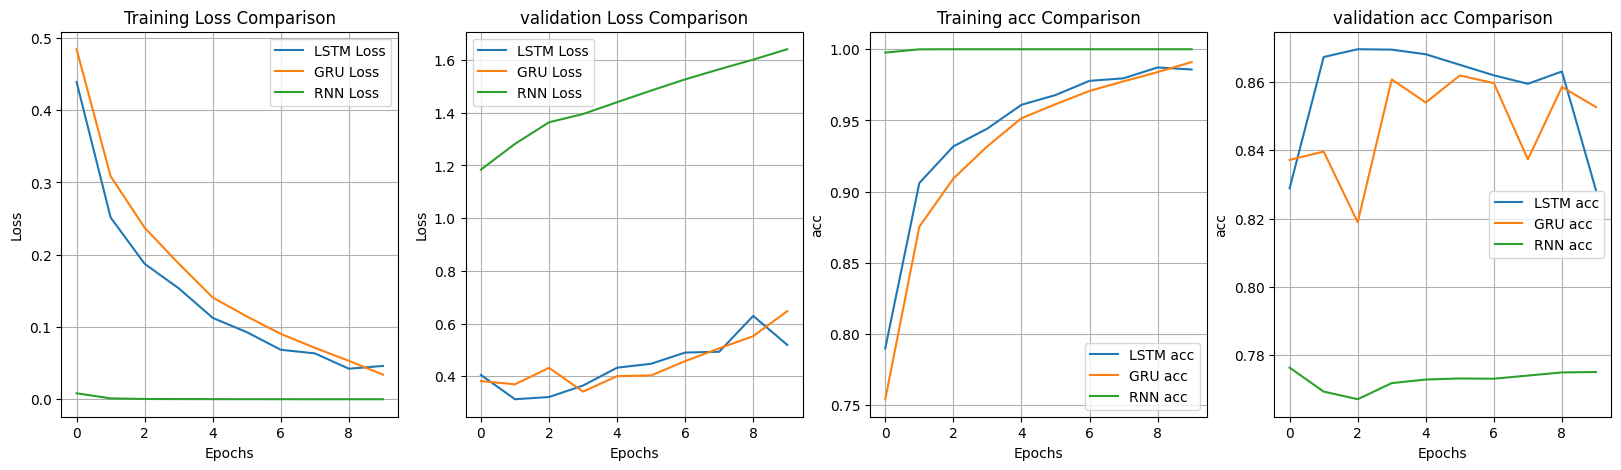

In [113]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].plot(history_lstm.history['loss'], label='LSTM Loss')  # Plot LSTM loss
ax[0].plot(history_gru.history['loss'], label='GRU Loss')  # Plot GRU loss
ax[0].plot(history.history['loss'], label='RNN Loss')  # Plot GRU loss
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss Comparison')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(history_lstm.history['val_loss'], label='LSTM Loss')  # Plot LSTM loss
ax[1].plot(history_gru.history['val_loss'], label='GRU Loss')  # Plot GRU loss
ax[1].plot(history.history['val_loss'], label='RNN Loss')  # Plot GRU loss
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('validation Loss Comparison')
ax[1].legend()
ax[1].grid(True)

ax[2].plot(history_lstm.history['accuracy'], label='LSTM acc')  # Plot LSTM loss
ax[2].plot(history_gru.history['accuracy'], label='GRU acc')  # Plot GRU loss
ax[2].plot(history.history['accuracy'], label='RNN acc')  # Plot GRU loss
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('acc')
ax[2].set_title('Training acc Comparison')
ax[2].legend()
ax[2].grid(True)

ax[3].plot(history_lstm.history['val_accuracy'], label='LSTM acc')  # Plot LSTM loss
ax[3].plot(history_gru.history['val_accuracy'], label='GRU acc')  # Plot GRU loss
ax[3].plot(history.history['val_accuracy'], label='RNN acc')  # Plot GRU loss
ax[3].set_xlabel('Epochs')
ax[3].set_ylabel('acc')
ax[3].set_title('validation acc Comparison')
ax[3].legend()
ax[3].grid(True)


In [114]:
new1 = 'This was worst movie. Please do not watch it. Waste of money and time.'
new2 = 'A must watch movie. I loved to watch it. It was just amazing!'

In [115]:
def predict(model, text):
  seq = tokenizer.texts_to_sequences([text])
  padded = pad_sequences(seq, maxlen=500, truncating='post')
  y_hat = model.predict(padded, verbose = 0)[0,0]
  return (y_hat, 'POSITIVE')  if y_hat > 0.5 else (1 - y_hat, 'NEGATIVE')

In [116]:
predict(model_rnn, new1)

(0.9999987500744965, 'NEGATIVE')

In [117]:
predict(model_GRU, new1)

(0.9997490468376782, 'NEGATIVE')

In [118]:
predict(model_lstm, new1)

(0.9987152691464871, 'NEGATIVE')

In [119]:
predict(model_GRU, new2)

(0.9988072, 'POSITIVE')

In [120]:
predict(model_lstm, new2)

(0.97334176, 'POSITIVE')

In [121]:
predict(model_rnn, new2)

(0.9999862, 'POSITIVE')